In [1]:
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline

from pclib.nn.models import ConvClassifierUs
from pclib.nn.layers import Conv2d
from pclib.optim.train import train
from pclib.optim.eval import track_vfe, accuracy
from pclib.utils.functional import format_y
from pclib.utils.customdataset import PreloadedDataset

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
device

device(type='cuda')

In [15]:

class TanhTransform(object):
    def __init__(self, a=1., b=0., c=1.0):
        self.a = a
        self.b = b
        self.c = c

    def __call__(self, img):
        return ((img * self.a).tanh() + self.b) * self.c

class PadTransform(object):
    def __call__(self, img):
        return F.pad(img, (2, 2, 2, 2), mode='constant', value=0)

class InvTanhTransform(object):
    def __call__(self, img):
        num = 1 + img
        div = (1 - img).clamp(min=1e-6)
        m = 0.5 * torch.log(num / div)
        return m

class SigmoidTransform(object):
    def __call__(self, img):
        return img.sigmoid()
    
class ReLUTanhTransform(object):
    def __call__(self, img):
        return F.relu(img.tanh())

class AddTransform(object):
    def __init__(self, add):
        self.add = add

    def __call__(self, img):
        return img + self.add

train_transform = transforms.Compose([
    transforms.ToTensor(),
    PadTransform(),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),                                
    transforms.Normalize((0.1307,), (0.3081,)),
    AddTransform(0.4242),
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    PadTransform(),
    # InvTanhTransform(),
    transforms.Normalize((0.1307,), (0.3081,)),
    AddTransform(0.4242),
    # SigmoidTransform(),
    # TanhTransform(a=2.0),
    # TanhTransform(a=1.0, b=1.0, c=0.5),
])

dataset = datasets.MNIST('../Datasets/', train=True, download=False, transform=transforms.ToTensor())
# # shorten dataset
# length = 1000
# dataset = torch.utils.data.Subset(dataset, range(length))

VAL_RATIO = 0.2
val_len = int(len(dataset) * VAL_RATIO)
train_len = len(dataset) - val_len
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_len, val_len])
train_dataset = PreloadedDataset.from_dataset(train_dataset, train_transform, device)
val_dataset = PreloadedDataset.from_dataset(val_dataset, val_transform, device)
INPUT_SHAPE = 784
NUM_CLASSES = 10

  0%|          | 0/48000 [00:00<?, ?it/s]

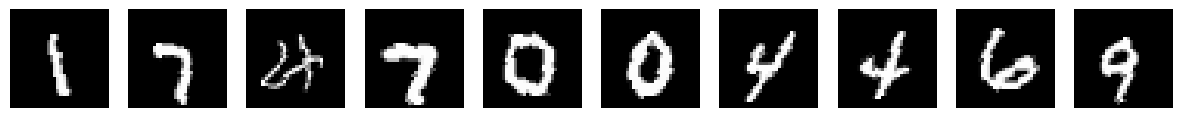

Max value:  tensor(3.2457, device='cuda:0')
Min value:  tensor(-1.2964e-05, device='cuda:0')


In [16]:
# Show some images
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes):
    img, label = train_dataset[i]
    ax.imshow(img.squeeze().cpu(), cmap='gray')
    ax.axis('off')
plt.show()

# print max min values
print('Max value: ', train_dataset.transformed_images.max())
print('Min value: ', train_dataset.transformed_images.min())

In [19]:
seed = 42
torch.manual_seed(seed)

model_name = 'same_init-relu_norm-shift'
model = ConvClassifierUs(
    bias=False, 
    symmetric=True, 
    precision_weighted=False,
    actv_fn=F.relu,
    steps=60,
    gamma=0.1,
    ).to(device)

In [18]:
# Train Loop
NUM_EPOCHS = 30
BATCH_SIZE = 1000

log_dir = f'examples/mnist/logs/revert/{model_name}'
train(
    model, 
    train_dataset, 
    val_dataset, 
    NUM_EPOCHS, 
    lr=0.0001,
    c_lr = 0.00,
    batch_size=BATCH_SIZE,
    reg_coeff=0.02,
    flatten=False,
    save_best=False,
    optim='AdamW',
    grad_mode='auto',
    log_dir=log_dir,
    minimal_stats=True,
)

NUM_EPOCHS = 15
train(
    model, 
    train_dataset, 
    val_dataset, 
    NUM_EPOCHS, 
    lr=0.0,
    c_lr=0.001,
    batch_size=BATCH_SIZE,
    reg_coeff=0.02,
    flatten=False,
    save_best=False,
    optim='AdamW',
    grad_mode='auto',
    log_dir=log_dir,
    minimal_stats=True,
)

KeyboardInterrupt: 

In [ ]:
kernel = 3
padding = 1
stride = 1
in_features = 1
out_features = 4

conv = torch.nn.Conv2d(in_features, out_features, kernel, stride, padding)
convt = torch.nn.ConvTranspose2d(out_features, in_features, kernel, stride, padding)

x = torch.randn(1, 1, 28, 28)
y = conv(x)
x_hat = convt(y)

print(f"x.shape: {x.shape}")
print(f"y.shape: {y.shape}")
print(f"x_hat.shape: {x_hat.shape}")


NameError: name 'torch' is not defined

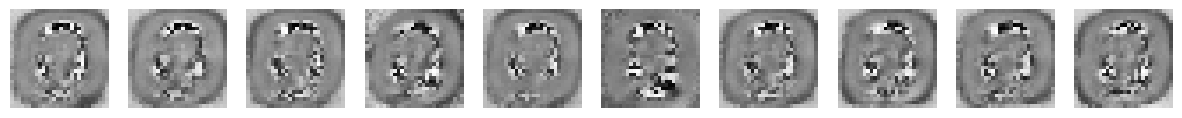

In [ ]:
targets = torch.arange(NUM_CLASSES).to(device)
y = format_y(targets, NUM_CLASSES)
_, state = model(y=y, lmda=0.00)
images = state[-1]['x']

fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes):
    img = images[i]
    ax.imshow(img.detach().squeeze().cpu().view(28,28), cmap='gray')
    ax.axis('off')

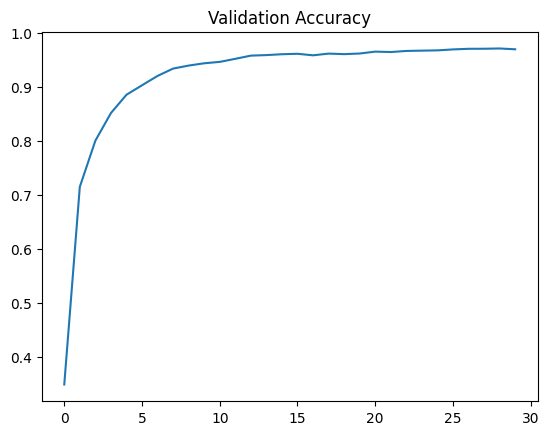

In [ ]:
plt.plot(stats['val_acc'])
plt.title("Validation Accuracy")
plt.show()

In [ ]:
def run():
    x = torch.randn(1000, 1, 28, 28).to(device)
    out = model(x, steps=100)

%timeit run()
for p in model.parameters():
    p.requires_grad = False
%timeit run()

1.28 s ± 1.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.03 s ± 2.31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# Current Accuracy and Error Rate
acc = accuracy(model, val_dataset, steps=0)
error = 100 * (1 - acc)
print(f'Current Val Acc: {acc} | error_rate: {error:0.2f} %')

RuntimeError: The size of tensor a (784) must match the size of tensor b (28) at non-singleton dimension 3

In [ ]:
# # Shows statistics over multiple models. models = [model1, model2, ...]


# train_vfes = torch.tensor([stats[i]['train_vfe'][-1] for i in range(num_models)])
# val_vfes = torch.tensor([stats[i]['val_vfe'][-1] for i in range(num_models)])
# val_accs = torch.tensor([stats[i]['val_acc'][-1] for i in range(num_models)])

# # Show statistics across models, std is nan if num_models = 1
# print(f"Tra VFE - mean: {train_vfes.mean():.3f} | std: {train_vfes.std():.3f} | min: {train_vfes.min():.3f} | max: {train_vfes.max():.3f}")
# print(f"Val VFE - mean: {val_vfes.mean():.3f} | std: {val_vfes.std():.3f} | min: {val_vfes.min():.3f} | max: {val_vfes.max():.3f}")
# print(f"Val Acc - mean: {val_accs.mean():.3f} | std: {val_accs.std():.3f} | min: {val_accs.min():.3f} | max: {val_accs.max():.3f}")

NameError: name 'num_models' is not defined

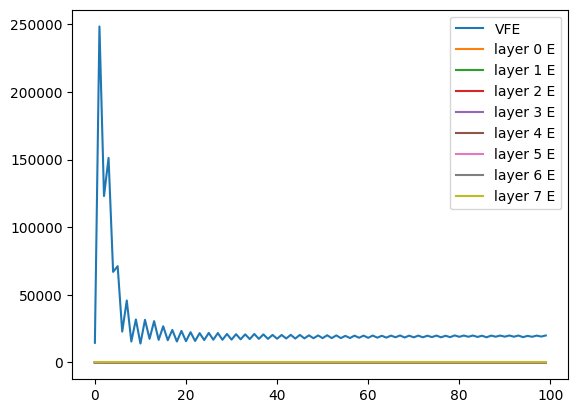

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


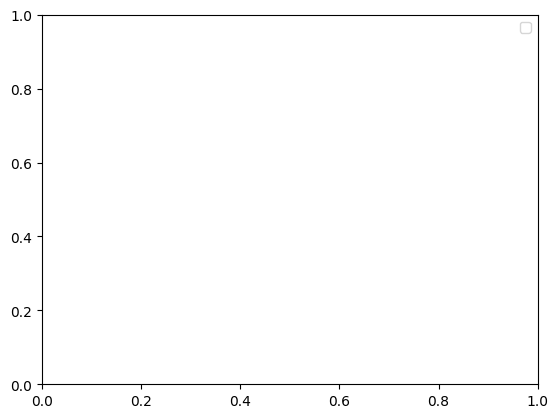

([14544.564453125,
  248454.734375,
  123059.4375,
  151269.3125,
  66996.734375,
  71204.890625,
  22840.83203125,
  45842.9453125,
  15495.349609375,
  31823.5234375,
  13997.9140625,
  31545.224609375,
  17461.4921875,
  30563.9375,
  16721.8203125,
  26767.0546875,
  16448.55859375,
  24053.990234375,
  15502.087890625,
  23353.767578125,
  15739.8017578125,
  22388.40625,
  15918.5224609375,
  21689.0234375,
  16593.091796875,
  21845.27734375,
  16839.75390625,
  21746.51953125,
  16776.6171875,
  21069.32421875,
  16904.375,
  20905.77734375,
  17109.24609375,
  20792.619140625,
  17305.44140625,
  21079.53515625,
  17459.16015625,
  20759.138671875,
  17455.578125,
  20373.95703125,
  17585.9765625,
  20342.2734375,
  17749.62890625,
  20418.30859375,
  17696.984375,
  20384.56640625,
  17825.017578125,
  20052.84765625,
  17916.97265625,
  20004.447265625,
  18007.40234375,
  20114.068359375,
  18021.1640625,
  20022.728515625,
  18028.55859375,
  19689.08203125,
  18059.74804

In [ ]:
from pclib.utils.functional import format_y
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)
images, y = next(iter(train_loader))
x = images
y = format_y(y, 10)

track_vfe(model, x, y, 100, plot_Es=True)

In [ ]:
assert isinstance(model.layers[0], PrecisionWeighted), "This cell only works for PrecisionWeighted layers"
# show diag of weight_var matrix as 28x28 image for layer 0
model = model
layer = 0
weight_var = model.layers[0].weight_var.detach().cpu().numpy()
# weight_var = model.layers[-1].weight_var.diag().reshape(28,28).detach().cpu().numpy()
plt.imshow(weight_var, cmap='gray')
plt.colorbar()
plt.show()
weight_var.min(), weight_var.max()


AssertionError: This cell only works for PrecisionWeighted layers